気象庁の月平均気温(金沢)と

https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3.php?prec_no=44&block_no=47662

日本アイスクリーム協会のアイスクリーム年間支出金額(金沢)

https://www.icecream.or.jp/biz/data/expenditures.html

を使ってアイスクリームの年間支出を予測します。

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import requests
import io
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [ ]:
URL = "https://drive.google.com/uc?id=1alN3yX201OAasdYy9hDgesIfr2Gia7jf"

r = requests.get(URL)
row_data = pd.read_csv(io.BytesIO(r.content))

In [ ]:
row_data.head()

,date,earnings,temperature
0,2014/1/1,396.0,3.9
1,2014/2/1,309.0,3.5
2,2014/3/1,447.0,7.4
3,2014/4/1,520.0,12.4
4,2014/5/1,803.0,18.0


In [ ]:
# float型にする
row_data.earnings = row_data.earnings.astype('float64')
row_data.temperature = row_data.temperature.astype('float64')
# datetime型にしてインデックスにする
row_data.date = pd.to_datetime(row_data.date)
data = row_data.set_index("date")

In [ ]:
data.head()

,earnings,temperature
date,,
2014-01-01,396.0,3.9
2014-02-01,309.0,3.5
2014-03-01,447.0,7.4
2014-04-01,520.0,12.4
2014-05-01,803.0,18.0


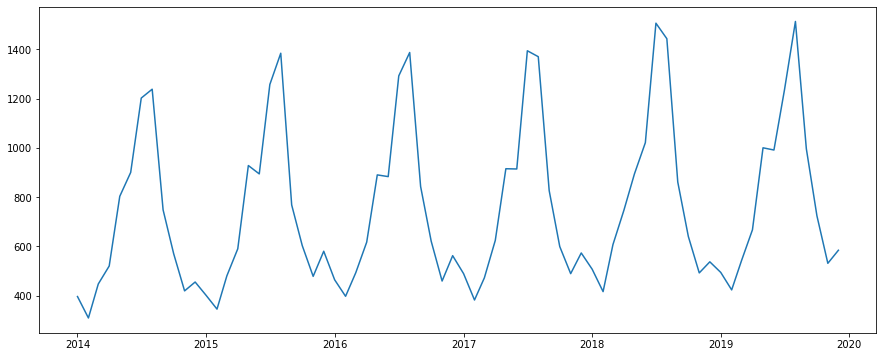

In [ ]:
# データの全体像
plt.plot(data.earnings)

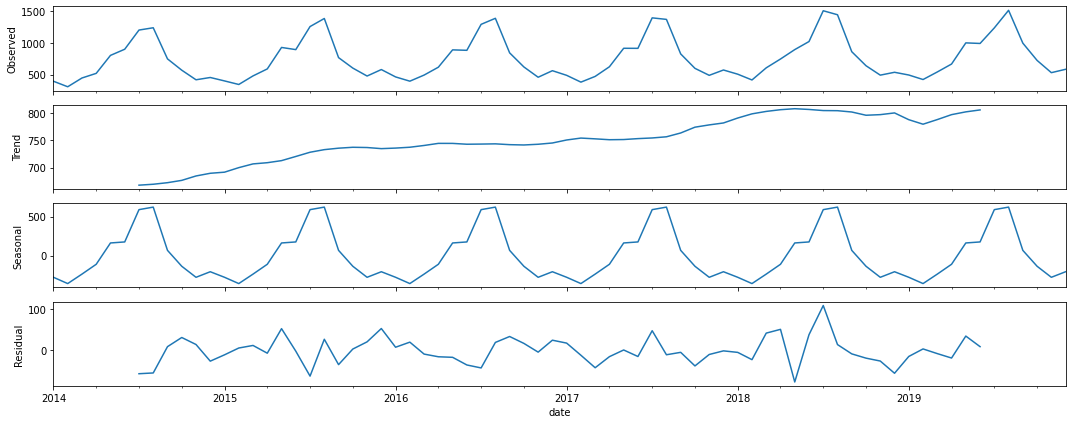

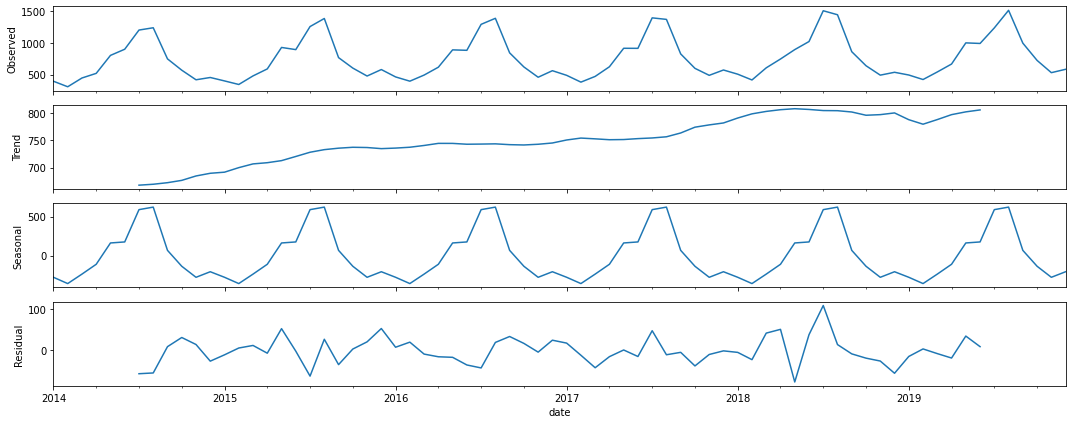

In [ ]:
# 時系列データを周期成分(このデータだと12ヶ月周期)、トレンド(全体の傾向)、外因性(自己相関では説明できない動き)、ホワイトノイズに分解
# 外因性と時系列データがほぼ同じ動きをしているのは、月ごとの平均気温を外因性として用意したから
seasonal_decompose_res = sm.tsa.seasonal_decompose(data.earnings, freq=12)
seasonal_decompose_res.plot()

In [ ]:
# トレンド成分を抜いて分析しやすくする
diff = data.earnings.diff()
diff = diff.dropna()


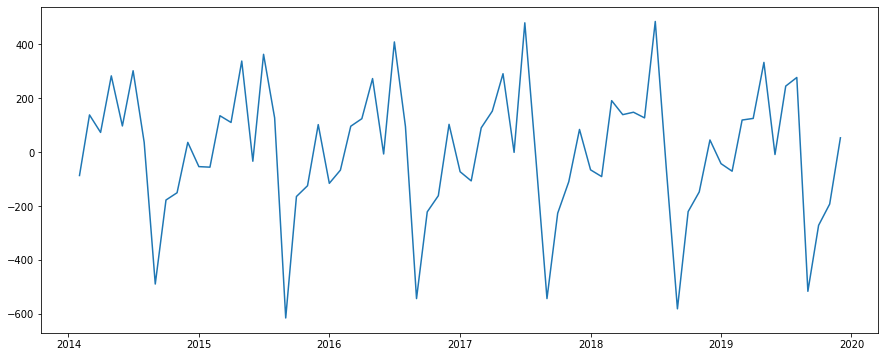

In [ ]:
plt.plot(diff)

In [ ]:
# データをトレーニングデータとテストデータに分割

train_data = data[data.index < "2019-06"]
# テストデータはテスト期間以前の日付も含まなければいけない
test_data = data[data.index >= "2019-05"]

In [ ]:
# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 2
max_sp = 1
max_sq = 1
max_sd = 1

pattern = max_p*(max_d + 1)*(max_q + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)

modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            train_data.earnings, order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.loc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.loc[num]["aic"] = sarima.aic
                        num = num + 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python

In [ ]:
# できたデータフレームからAIC(統計モデルの良さを評価する指標)が小さいものを検索
modelSelection.sort_values(by='aic').head(10)

,model,aic
91,"order=(1,2,3), season=(0,1,1)",384.799
187,"order=(2,2,3), season=(0,1,1)",386.732
95,"order=(1,2,3), season=(1,1,1)",386.812
283,"order=(3,2,3), season=(0,1,1)",388.628
191,"order=(2,2,3), season=(1,1,1)",391.284
155,"order=(2,1,3), season=(0,1,1)",391.475
59,"order=(1,1,3), season=(0,1,1)",391.673
251,"order=(3,1,3), season=(0,1,1)",392.092
287,"order=(3,2,3), season=(1,1,1)",393.138
63,"order=(1,1,3), season=(1,1,1)",393.237


In [ ]:
パラメータが1,2,3,0,1,1のモデルがAIC最小になるので、これを採用してモデルを推定
SARIMA_1_2_3_011 = sm.tsa.SARIMAX(train_data.earnings, order=(1,2,3), seasonal_order=(0,1,1,12)).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
# Ljungbox検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_1_2_3_011.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

,p-value
0,0.000871
1,0.002296
2,0.002928
3,0.005049
4,0.008224
5,0.013978
6,0.007571
7,0.000144
8,0.000047
9,0.000089


In [ ]:
# 2番目にAICが小さいモデルの推定
SARIMA_2_2_3_011 = sm.tsa.SARIMAX(train_data.earnings, order=(2,2,3), seasonal_order=(0,1,1,12)).fit()
# Ljungbox検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_2_2_3_011.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,p-value
0,0.000872
1,0.002178
2,0.002189
3,0.004292
4,0.007128
5,0.012323
6,0.007075
7,0.000120
8,0.000039
9,0.000076


In [ ]:
# 3番目にAICが小さいモデルの推定
SARIMA_1_2_3_111 = sm.tsa.SARIMAX(train_data.earnings, order=(1,2,3), seasonal_order=(1,1,1,12)).fit()
# Ljungbox検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_1_2_3_111.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,p-value
0,0.000855
1,0.002224
2,0.002797
3,0.004836
4,0.007967
5,0.013530
6,0.007224
7,0.000137
8,0.000043
9,0.000082


In [ ]:
# 4番目にAICが小さいモデルの推定
SARIMA_3_2_3_011 = sm.tsa.SARIMAX(train_data.earnings, order=(3,2,3), seasonal_order=(0,1,1,12)).fit()
# Ljungbox検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_3_2_3_011.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,p-value
0,0.000871
1,0.002147
2,0.002210
3,0.004216
4,0.006903
5,0.011784
6,0.006690
7,0.000113
8,0.000037
9,0.000072


In [ ]:
# 5番目にAICが小さいモデルの推定
SARIMA_2_2_3_111 = sm.tsa.SARIMAX(train_data.earnings, order=(2,2,3), seasonal_order=(1,1,1,12)).fit()
# Ljungbox検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_2_2_3_111.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,p-value
0,0.000861
1,0.002139
2,0.002153
3,0.004234
4,0.007056
5,0.012151
6,0.006882
7,0.000120
8,0.000038
9,0.000074


In [ ]:
# 6番目にAICが小さいモデルの推定
SARIMA_2_1_3_011 = sm.tsa.SARIMAX(train_data.earnings, order=(2,1,3), seasonal_order=(0,1,1,12)).fit()
# Ljungbox検定
ljungbox_result = sm.stats.diagnostic.acorr_ljungbox(SARIMA_2_1_3_011.resid, lags=10)
df_ljungbox_result = pd.DataFrame({"p-value":ljungbox_result[1]})
df_ljungbox_result[df_ljungbox_result["p-value"] <  0.05]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


,p-value


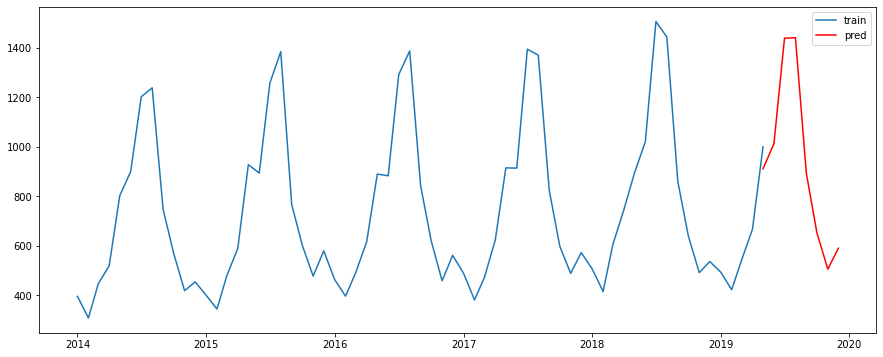

In [ ]:
# 予測
pred = SARIMA_2_1_3_011.predict('2019-05-01', '2019-12-01')
# 実データと予測結果の図示
plt.plot(train_data.earnings, label="train")
plt.plot(pred, "r", label="pred")
plt.legend()

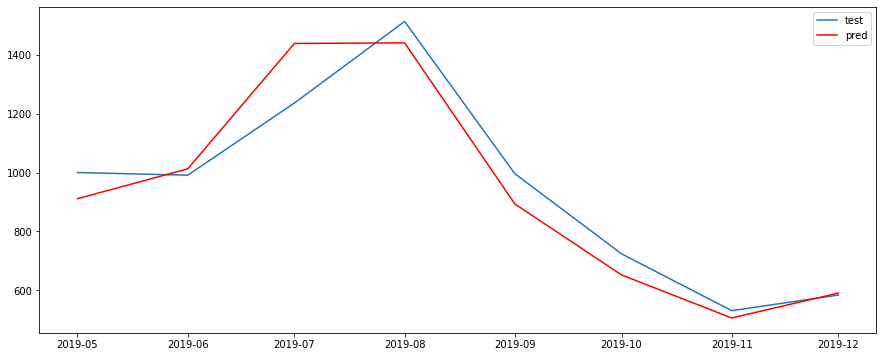

In [ ]:
# 予測評価
pred = SARIMA_2_1_3_011.predict('2019-05-01', '2019-12-01')
# 実データと予測結果の図示
plt.plot(test_data.earnings, label="test")
plt.plot(pred, "r", label="pred")
plt.legend()

結果：それっぽい予測を行うことは出来た。
 
 時系列分析のことについて少し調べて行ったが理解できている気がしない